In [1]:
%load_ext autoreload
%autoreload 2

import os
import time

import sys
sys.path.append(os.path.join(os.environ['GORDON_REPO_DIR'], 'utilities'))
from utilities2015 import *

sys.path.append('/oasis/projects/nsf/csd181/yuncong/opencv-2.4.9/release/lib/python2.7/site-packages')
import cv2

from joblib import Parallel, delayed

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from skimage.filters.rank import entropy
from skimage.morphology import remove_small_objects, disk
from skimage.measure import label, regionprops
from skimage.color import rgb2gray
from skimage.io import imread, imsave
from skimage import img_as_float

from sklearn import mixture

In [ ]:
# section_ind = 66
# dm = DataManager(stack='MD589', section=section_ind, segm_params_id='tSLIC200', load_mask=True)
# # dm.mask = rescale(dm.thumbmail_mask.astype(np.bool), 32).astype(np.bool)
# # display(dm.mask)

In [3]:
def generate_mask(img):

    h, w = img.shape
    
    e = entropy(img, disk(5))
    
    clf = mixture.GMM(n_components=2, covariance_type='full')
    clf.fit(np.atleast_2d(e[e > 0.1]).T)

    means = np.squeeze(clf.means_)

    order = np.argsort(means)
    means = means[order]

    covars =np.squeeze(clf.covars_)
    covars = covars[order]

    weights = clf.weights_
    weights = weights[order]

    counts, bins = np.histogram(e.flat, bins=100, density=True);

    gs = np.array([w * 1./np.sqrt(2*np.pi*c) * np.exp(-(bins-m)**2/(2*c)) for m, c, w in zip(means, covars, weights)])

    thresh = bins[np.where(gs[-1] - gs[-2] < 0)[0][-1]]

    v = e > thresh

    l = label(v, background=0)
    mask = l == np.argmax([p.area for p in regionprops(l+1)])
    
    mask = ~remove_small_objects(~mask, min_size=10000, connectivity=8)
    
    l = label(v)
    l[v > 0] = -1
    props = regionprops(l)
    
    border_holes = np.where([np.any(p.coords[:,0] == 0) or np.any(p.coords[:,1] == 0) \
                             or np.any(p.coords[:,0] == h-1) or np.any(p.coords[:,1] == w-1) 
                             for p in props])[0]

    for i in border_holes:
        c = props[i].coords
        mask[c[:,0], c[:,1]] = 0
    
    return mask

In [4]:
def f(stack, sec):
    img = rgb2gray(imread('/home/yuncong/CSHL_data_processed/'+stack+'_thumbnail_aligned_cropped/'+stack+'_%04d_thumbnail_aligned_cropped.tif'%sec))
    
    try:
        mask = generate_mask(img)
    except:
        raise Exception('%d'%sec)
    
    img2 = img.copy()
    img2[~mask] = 0

    imsave('/home/yuncong/CSHL_data_processed/'+stack+'_thumbnail_aligned_cropped_mask/'+stack+'_%04d_thumbnail_aligned_cropped_mask.png'%sec, img_as_float(mask))
    imsave('/home/yuncong/CSHL_data_processed/'+stack+'_thumbnail_aligned_cropped_masked/'+stack+'_%04d_thumbnail_aligned_cropped_masked.png'%sec, img2)

In [ ]:
stack ='MD592'

mask_dir = '/home/yuncong/CSHL_data_processed/'+stack+'_thumbnail_aligned_cropped_mask/'
masked_tb_dir = '/home/yuncong/CSHL_data_processed/'+stack+'_thumbnail_aligned_cropped_masked/'

if not os.path.exists(mask_dir):
    os.makedirs(mask_dir)
if not os.path.exists(masked_tb_dir):
    os.makedirs(masked_tb_dir)

first, last = section_range_lookup[stack]
    
_ = Parallel(n_jobs=16)(delayed(f)(stack, sec) for sec in range(first, last+1))

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [5]:
img = rgb2gray(imread('/home/yuncong/CSHL_data_processed/MD594_thumbnail_aligned/MD594_0087_thumbnail_aligned.tif'))

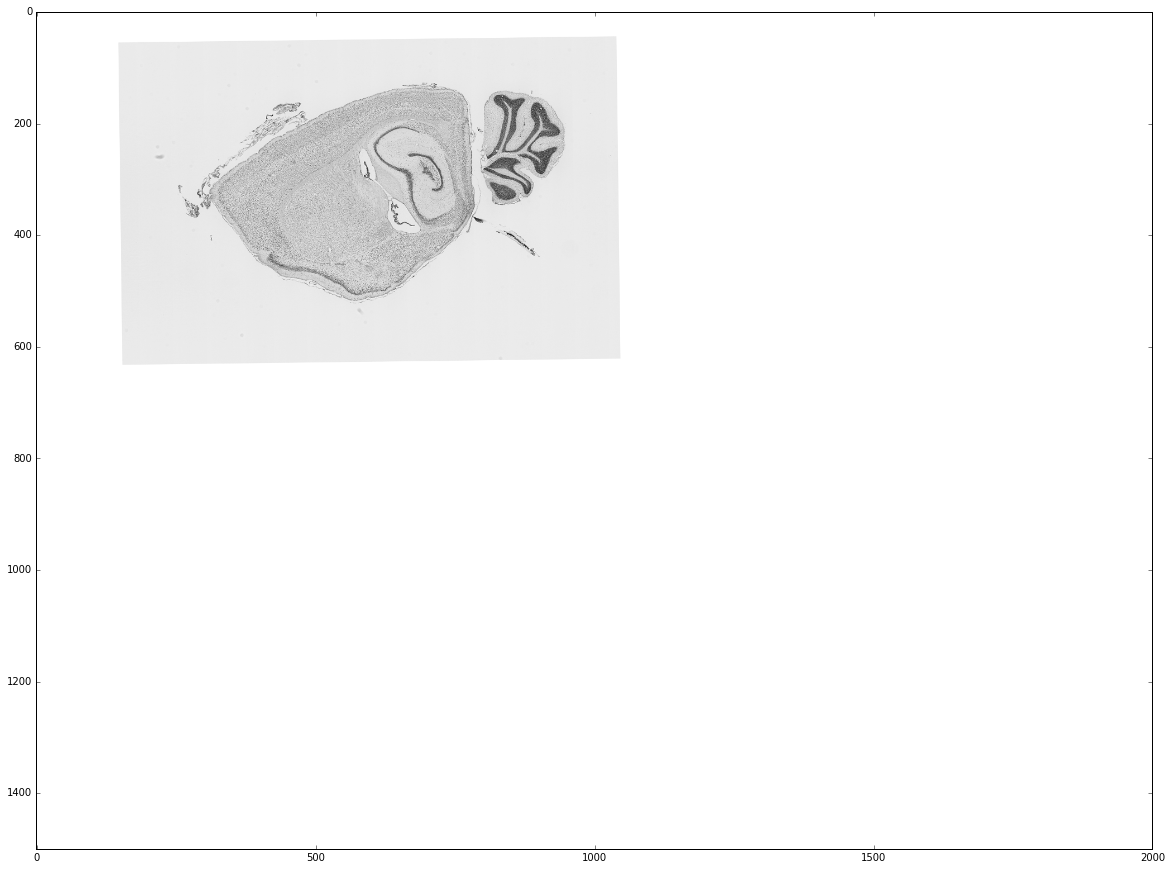

In [6]:
plt.figure(figsize=(20,20));
plt.imshow(img, cmap=plt.cm.gray);

2.75984979295


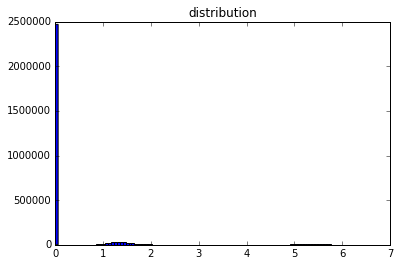

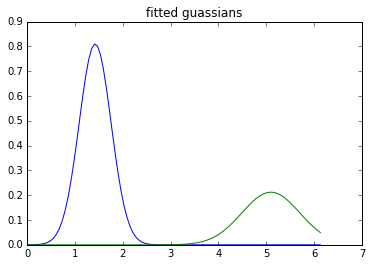

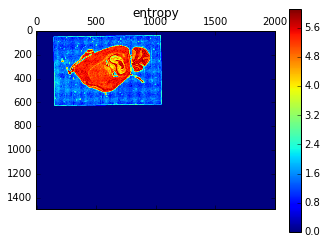

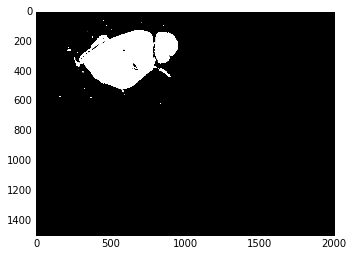

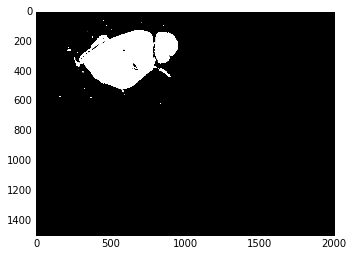

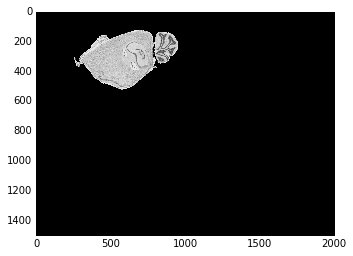

In [13]:
h, w = img.shape
e = entropy(img, disk(5))

plt.figure();
plt.title('distribution');
plt.hist(e.flatten(), bins=100);

clf = mixture.GMM(n_components=2, covariance_type='full')
clf.fit(np.atleast_2d(e[e > 0.1]).T)

means = np.squeeze(clf.means_)

order = np.argsort(means)
means = means[order]

covars =np.squeeze(clf.covars_)
covars = covars[order]
                
weights = clf.weights_
weights = weights[order]

counts, bins = np.histogram(e.flat, bins=100, density=True);

gs = np.array([w * 1./np.sqrt(2*np.pi*c) * np.exp(-(bins-m)**2/(2*c)) for m, c, w in zip(means, covars, weights)])

plt.figure();
plt.title('fitted guassians');
plt.plot(bins, gs.T)

thresh = bins[np.where(gs[-1] - gs[-2] < 0)[0][-1]]
print thresh

v = e > thresh

plt.figure();
plt.matshow(e);
plt.colorbar();
plt.title('entropy');

plt.figure();
plt.imshow(v, cmap=plt.cm.gray);

l = label(v, background=0)
mask = l == np.argmax([p.area for p in regionprops(l+1)])

plt.figure();
plt.imshow(v, cmap=plt.cm.gray);

mask = ~remove_small_objects(~mask, min_size=10000, connectivity=8)

l = label(v)
l[v > 0] = -1
props = regionprops(l)

border_holes = np.where([np.any(p.coords[:,0] == 0) or np.any(p.coords[:,1] == 0) \
                         or np.any(p.coords[:,0] == h-1) or np.any(p.coords[:,1] == w-1) 
                         for p in props])[0]

for i in border_holes:
    c = props[i].coords
    mask[c[:,0], c[:,1]] = 0

img2 = img.copy()
img2[~mask] = 0

plt.figure();
plt.imshow(img2, cmap=plt.cm.gray);

# imsave('/home/yuncong/CSHL_data_processed/MD593_thumbnail_mask/MD593_%04d_thumbnail_aligned_cropped_mask.png'%171, img_as_float(mask))